# Step Length Distribution Analysis

Run simulations on different agent types and collect their step lengths. 
Then analyse whether any of them follow power law distribution. 

Note:
Because we select the step lengths from the agents only a single iteration is used.
This can be balanced by using more agents or increasing total_time.


In [1]:
import os
os.chdir(os.path.join(os.getcwd(), "../code"))
import numpy as np
from parameters import Params
from simulation import Simulation
import matplotlib.pyplot as plt
from agent import ReservoirAgent, LévyAgent, ExponentialAgent
from environment import Environment
import powerlaw
from tqdm import tqdm
from config import DATA_PATH
from pathlib import Path
import pickle

tolerance = 0.01

params = Params.from_json('parameters.json')
params.save = False
params.iterations_per_epoch = 1
data = []
environment = Environment(params)
folder = 'step_lengths'
path = Path(DATA_PATH) / folder
path.mkdir(parents=True, exist_ok=True)

# Reservoir Agent

In [2]:
data = []
params.type = 'reservoir'
params.agent = ReservoirAgent

sigma_range = [0.032, 0.04, 0.05]

for sigma in tqdm(sigma_range):
    params.standard_deviation = sigma
    sim = Simulation(params, params.agent)
    population = sim.run_epoch(sim.set_up_population(None), environment)
    step_lengths = []
    for agent in population:
        step_counter = 1
        for output in agent.output_log:
            if abs(output) > 1 - tolerance or abs(output) < tolerance:
                step_counter += 1
            else:
                step_lengths.append(step_counter)
                step_counter = 1
        step_lengths.append(step_counter)
    data.append(step_lengths)

with open(path / 'data.pkl', 'wb') as f:
    pickle.dump(data, f)

100%|██████████| 3/3 [05:10<00:00, 103.53s/it]


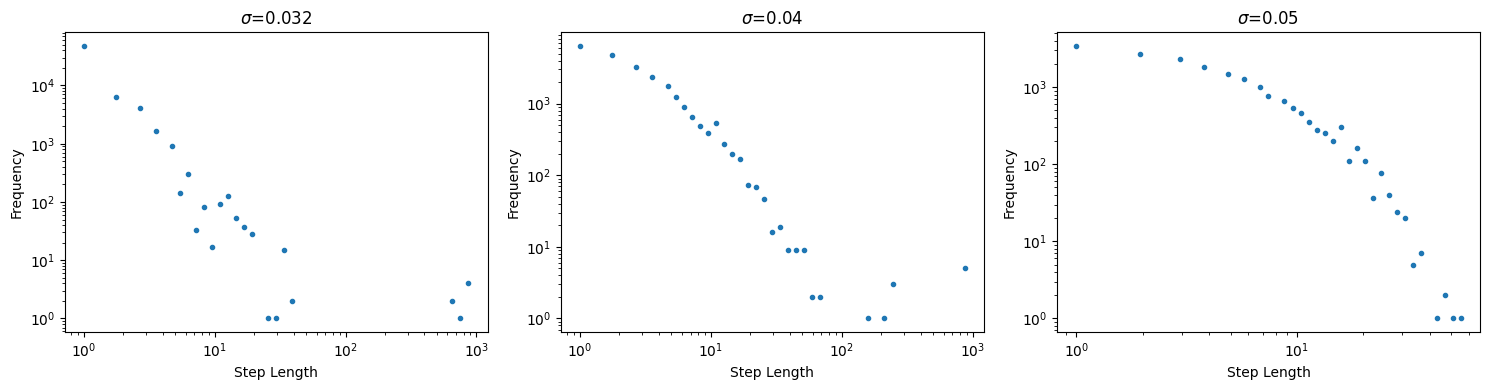

In [3]:
with open(path / 'data.pkl', 'rb') as f:
    data = pickle.load(f)

n = len(sigma_range)
cols = 3
rows = (n + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axes = axes.flatten()

for i, sigma in enumerate(sigma_range):
    ax = axes[i]
    counts, bins = np.histogram(data[i], bins=np.logspace(np.log10(min(data[i])), np.log10(max(data[i])), 50))
    ax.loglog(bins[:-1], counts, marker='.', linestyle='none')
    ax.set_title(r'$\sigma$=' + str(round(sigma, 3)))
    ax.set_xlabel('Step Length')
    ax.set_ylabel('Frequency')

for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.savefig(path / 'log-log_step_lengths_reservoir_separate.svg', format='svg')

# Lévy Agent

In [4]:
params.type = 'levy'
params.agent = LévyAgent
sim = Simulation(params, params.agent)
population = sim.run_epoch(sim.set_up_population(None), environment)
step_lengths = np.array([])
for agent in population:
    step_lengths = np.concatenate((step_lengths, agent.step_length_log))
data.append(step_lengths)

# Exponential Agent

In [5]:
params.type = 'exponential'
params.agent = ExponentialAgent
sim = Simulation(params, params.agent)
population = sim.run_epoch(sim.set_up_population(None), environment)
step_lengths = np.array([])
for agent in population:
    step_lengths = np.concatenate((step_lengths, agent.step_length_log))
data.append(step_lengths)

# Visualization

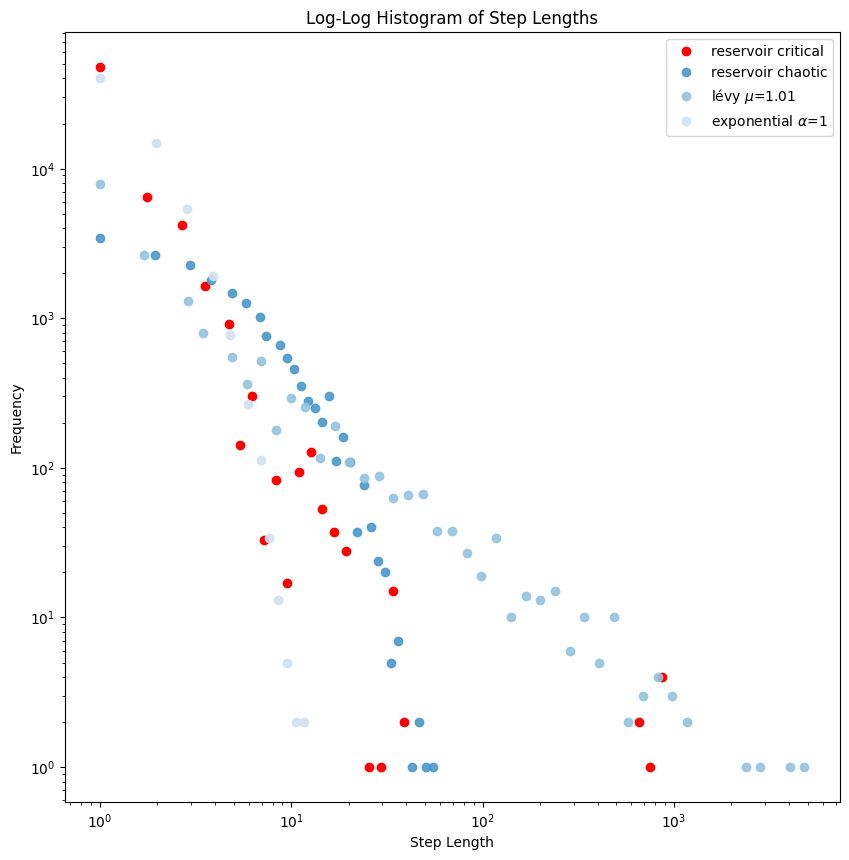

In [13]:
plt.figure(figsize = (10,10))

import matplotlib.cm as cm

shades = [cm.Blues(i) for i in np.linspace(1, 0.2, len(data))]

labels = ['reservoir critical', 'skip', 'reservoir chaotic', r'lévy $\mu$=' + str(params.mu), r'exponential $\alpha$=' + str(params.alpha)]

for i in range(len(data)):
    if i == 1:
        continue
    opacity = 0.9
    color = shades[i]
    if i == 0:
        opacity = 1
        color = 'r'
    counts, bins = np.histogram(data[i], bins=np.logspace(np.log10(min(data[i])), np.log10(max(data[i])), 50))
    plt.loglog(bins[:-1], counts, marker='o', linestyle='none', color=color, label=labels[i], alpha=opacity)

plt.xlabel('Step Length')
plt.ylabel('Frequency')
plt.legend()
plt.title('Log-Log Histogram of Step Lengths')
plt.savefig(path / 'log-log_step_lengths.svg', format='svg')

# Figure out $\mu$

In [7]:
assert(min(data[0]) == 1)
assert(min(data[3]) == 1)

fit_critical_reservoir = powerlaw.Fit(data[0], xmin=1, discrete=True)
fit_levy = powerlaw.Fit(data[3], xmin=1, discrete=True)

print(f"alpha: {fit_critical_reservoir.alpha:.2f}")
print(f"alpha: {fit_levy.alpha:2f}")

alpha: 2.07
alpha: 1.674889


# How Does $\mu$ Depend on $\sigma$?

In [8]:
# params.type = 'reservoir'
# params.agent = ReservoirAgent
# params.population_size = 50

# sigma_range = np.arange(0.03, 0.04, 0.0002)
# data = []

# for sigma in tqdm(sigma_range):
#     params.standard_deviation = sigma
#     sim = Simulation(params, params.agent)
#     population = sim.run_epoch(sim.set_up_population(None), environment)
#     step_lengths = np.array([])
#     for agent in population:
#         step_counter = 1
#         for output in agent.output_log:
#             if abs(output) > 1 - tolerance or abs(output) < tolerance:
#                 step_counter += 1
#             else:
#                 step_lengths = np.append(step_lengths, step_counter)
#                 step_counter = 1
#     data.append(step_lengths)


In [9]:
# mu_values = []

# for i in range(len(data)):
#     fit = powerlaw.Fit(data[i], xmin=1, discrete=True)
#     mu_values.append(fit.alpha)

# plt.plot(sigma_range, mu_values)
# plt.xlabel(r'$\sigma$')
# plt.ylabel(r'$\mu$')
# plt.title('Power Law Parameter vs Standard Deviation')
# plt.show()